In [1]:
from bn256 import *
import random
from copy import copy
import time
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
SIZE = 624

In [3]:
def timer(func):
    def _func(*args, **kwargs):
        t = time.process_time()
        res = func(*args, **kwargs)
        t = time.process_time() - t
        print('{0}: time elapsed {1:.8f} m.' .format(func.__name__, t / 60))
        return res

    return _func

In [4]:
def inverse_G1(curve):
    inv = copy(curve)
    inv.y = inv.y.additive_inverse()
    return inv

In [5]:
def inverse_G2(twist):
    inv = copy(twist)
    inv.negate()
    return inv

In [6]:
def transfer_vec_to_G1(vec):
    res = np.zeros(vec.shape, dtype=object)
    res[vec == 1] = curve_G
    res[vec == -1] = inverse_G1(curve_G)
    return res

In [7]:
def transfer_vec_to_G2(vec):
    res = np.zeros(vec.shape, dtype=object)
    res[vec == 1] = twist_G
    res[vec == -1] = inverse_G2(twist_G)
    return res

In [8]:
def gen_keys(size):
    return tuple(random.randrange(2, order) for i in range(size))

In [9]:
h1, h2 = random.randrange(2, order), random.randrange(2, order)
H1, H2 = curve_G.scalar_mul(h1), twist_G.scalar_mul(h2)

In [10]:
@timer
def master_key_generation(n):
    s, t = gen_keys(n), gen_keys(n)
    u, v = gen_keys(n + 2), gen_keys(n + 2)
    gen1_h = tuple(point_add(curve_G.scalar_mul(si), H1.scalar_mul(ti)) for si, ti in zip(s, t))
    gen2_h = tuple(point_add(twist_G.scalar_mul(ui), H2.scalar_mul(vi)) for ui, vi in zip(u, v))
    return gen1_h, s, t, gen2_h, u, v

In [11]:
@timer
def decryption_key_generation(gen2_h, s, t, v1points):
    n = v1points.size
    
    r0 = random.randrange(2, order)
    reg_template = [twist_G.scalar_mul(r0), H2.scalar_mul(r0)]
    
    d03 = v1points[0].scalar_mul(s[0])
    d04 = v1points[0].scalar_mul(t[0])
    for i in range(1, n):
        d03 = point_add(d03, v1points[i].scalar_mul(s[i]))
        d04 = point_add(d04, v1points[i].scalar_mul(t[i]))
    reg_template.append(point_add(inverse_G2(d03), gen2_h[0].scalar_mul(r0)))
    reg_template.append(point_add(inverse_G2(d04), gen2_h[1].scalar_mul(r0)))

    for i in range(n):
        reg_template.append(point_add(v1points[i], gen2_h[i + 2].scalar_mul(r0)))
    
    return tuple(reg_template)

In [12]:
@timer
def encryption_authentication(gen1_h, u, v, v2points):
    n = v2points.size
    
    r0 = random.randrange(2, order)
    auth_template = [curve_G.scalar_mul(0), curve_G.scalar_mul(0), curve_G.scalar_mul(r0), H1.scalar_mul(r0)]
    
    for ci, h in zip(v2points, gen1_h):
        auth_template.append(point_add(ci, h.scalar_mul(r0)))
        
    c01 = auth_template[2].scalar_mul(u[0])
    c02 = auth_template[2].scalar_mul(v[0])
    for i in range(1, n + 2):
        c01 = point_add(c01, auth_template[i + 2].scalar_mul(u[i]))
        c02 = point_add(c02, auth_template[i + 2].scalar_mul(v[i]))
    
    auth_template[0] = point_add(auth_template[0], inverse_G1(c01))
    auth_template[1] = point_add(auth_template[1], inverse_G1(c02))
    
    return tuple(auth_template)

In [13]:
gt = optimal_ate(twist_G, curve_G)
logarithmic_table = [gt.exp(i) for i in range(SIZE, int(SIZE - 0.3 * SIZE), -2)]

In [14]:
@timer
def decryption_authentication(DK, CT):
    d = optimal_ate(DK[0], CT[0])
    for i in range(1, SIZE + 4):
        d = d.mul(optimal_ate(DK[i], CT[i]))
    return d in logarithmic_table # hamminge_distance < 0.3

In [15]:
def iris_extractor(img):
    rows, cols, _ = img.shape
    gray_roi = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray_roi, (7, 7), 0)

    _, threshold = cv.threshold(blurred, 100, 255, cv.THRESH_BINARY)

    circles = cv.HoughCircles(threshold, cv.HOUGH_GRADIENT, 2, int(min(rows, cols) / 2))
    circles = np.uint16(np.around(circles))
    circle = max(circles[0, :], key=lambda c: c[2])

    x, y, r = circle
    iris = img[y - r : y + r, x - r : x + r]

    x, y, r = circle
    cv.circle(iris, (r, r), 2 * r, (255, 255, 255), 2 * r - 2)


    iris_gray = cv.cvtColor(iris, cv.COLOR_BGR2GRAY)
    _, iris_threshold = cv.threshold(iris_gray, 96, 255, cv.THRESH_BINARY)


    return cv.resize(iris_threshold, (26, 24))

In [16]:
@np.vectorize
def vec_to_binary(a):
    return 1 if a == 0 else -1

In [17]:
def img_to_binary_vector(img):
    res = img.copy()
    res.shape = (SIZE,)
    res = vec_to_binary(res)
    return res

In [18]:
img1 = cv.imread('eye_image1.jpg')
img2 = cv.imread('eye_image2.png')

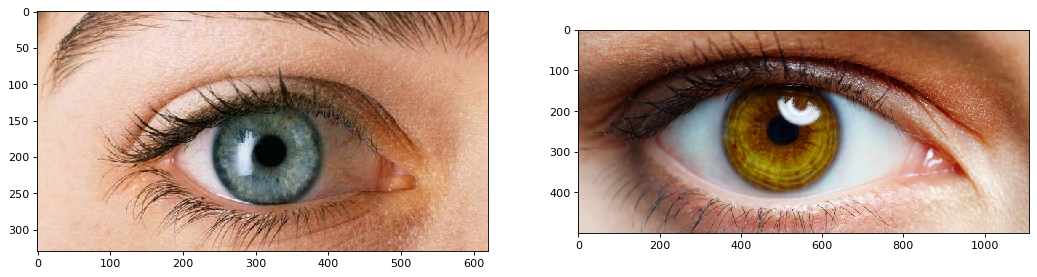

In [19]:
plt.figure(num=None, figsize=(16, 14), dpi=80)
for i, img in enumerate((img1, img2)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

plt.show()

In [20]:
iris_img1 = iris_extractor(img1)
iris_img2 = iris_extractor(img2)

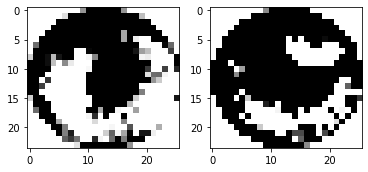

In [21]:
plt.figure()
for i, img in enumerate((iris_img1, iris_img2)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

plt.show()

In [22]:
v1, v2 = img_to_binary_vector(iris_img1), img_to_binary_vector(iris_img2)

In [23]:
v1

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,
        1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1

In [24]:
v1points = transfer_vec_to_G2(v1)
v2points = transfer_vec_to_G1(v2)

In [25]:
gen1_h, s, t, gen2_h, u, v = master_key_generation(SIZE)

master_key_generation: time elapsed 5.80729167 m.


In [26]:
DK = decryption_key_generation(gen2_h, s, t, v1points)

decryption_key_generation: time elapsed 7.07135417 m.


In [27]:
v1points_auth_temp = transfer_vec_to_G1(v1)
CT1 = encryption_authentication(gen1_h, u, v, v1points_auth_temp)

encryption_authentication: time elapsed 1.78906250 m.


In [28]:
CT2 = encryption_authentication(gen1_h, u, v, v2points)

encryption_authentication: time elapsed 1.73776042 m.


In [29]:
decryption_authentication(DK, CT1)

decryption_authentication: time elapsed 6.71666667 m.


True

In [30]:
decryption_authentication(DK, CT2)

decryption_authentication: time elapsed 6.90260417 m.


False